In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1) # this line may cause trouble since the page has connection issues
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape # 70000 images of 28 per 28 pixels, which are 784 "features" corresponding to pixel intensity (0 = white, 255 = black)

(70000, 784)

In [3]:
y.shape

(70000,)

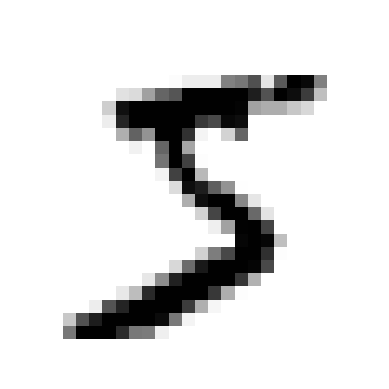

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

#some_digit = X[0]
some_digit = X.loc[0]
#some_digit_image = some_digit.reshape(28, 28)
some_digit_image = np.array(some_digit)
some_digit_image = some_digit_image.reshape(28, 28)

#plt.imshow(some_digit_image, cmap="binary")
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

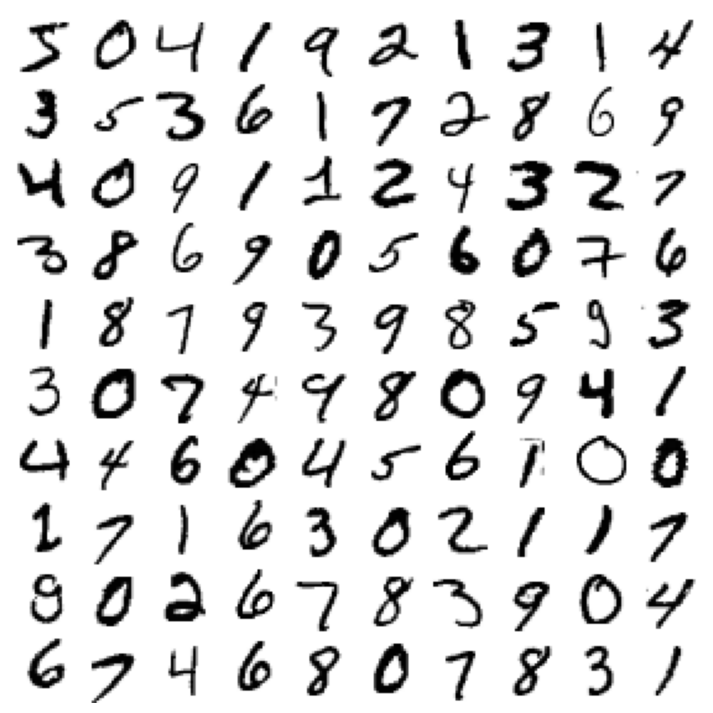

In [6]:
# Let's look at some digits in the dataset : (Don't worry about the code , just take a look at the digits !)
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary)
    plt.axis("off")
    
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [7]:
import numpy as np

y = y.astype(np.uint8) # label is a string, we are changing it to integer

# let's separate the set into a train dataset and a test dataset
# MNIST is already separeted into train set (first 60000) and test set (last 10000)
# trai set is also already shuffled and ready for cross-validation
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

In [8]:
# now let's create a classificator (or 5-detector) that identifies "5" and "not-5"
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [10]:
# let's evaluate perfomance, starting with accuracy using cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# let's verify creating a classifier that searches the "not-5"
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# the accuracy is "array([0.91125, 0.90855, 0.90915])", so 90% of the time the model guess correctly
# the problem is that only the 10% of the images are 5s, so if the model always says that the image is not a 5, then the accuracy is 90%
# between a model or not having a model, the accuracy is the same, so accuracy is not always the correct performance measure

array([0.91125, 0.90855, 0.90915])

In [12]:
# we will try another method called confusion matrix, which counts the times the model confused one instance with another
# we need a set of predictions to compare against, without touching the test set
# we are using the function cross_val_predict
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# first row consideres non-5 images, first column are non-5s and the second are 5s
# element 11 is correctly classified non-5s
# element 12 is wrongly classified 5s
# second row consideres 5 images, first column are non-5s and the second are 5s
# element 21 is wrongly classified 5s
# element 22 is correctly classified non-5s

array([[53892,   687],
       [ 1891,  3530]])

In [14]:
# let's pretend that we have prefect predictions from our model, wrongly classified images should be equal to 0
y_train_prefect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [15]:
# it's more useful to use precision and recall metrics based on confusion matrix
# precision = TP/(TP+FP) ; recall = TP/(TP+FN)
# where TP = True Positives, FP = False Positives; and FN = False Negatives
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == element 22 / (element 22 + element 12)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred) # == element 22 / (element 22 + element 21)

0.6511713705958311

In [17]:
# it's often more useful to combine precision and recall into a single metric called F1 score
# F1 score is the harmonic mean of both metrics
# F1 = 2 / ((1/precision) + (1/recall))
# F1 = 2 * (precision*recall)/(precision+recall)
# F1 = TP / (TP + ((FN+FP) / 2))
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [18]:
# precision and recall metrics depend on the model's threshold
y_scores = sgd_clf.decision_function([some_digit]) # we can't change the threshold, but we can try to find it
y_scores

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # threshold is higher than 0

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # threshold is lower than 8000

array([False])

In [21]:
# let's determine which threshold to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # first we get all the scores for each instance

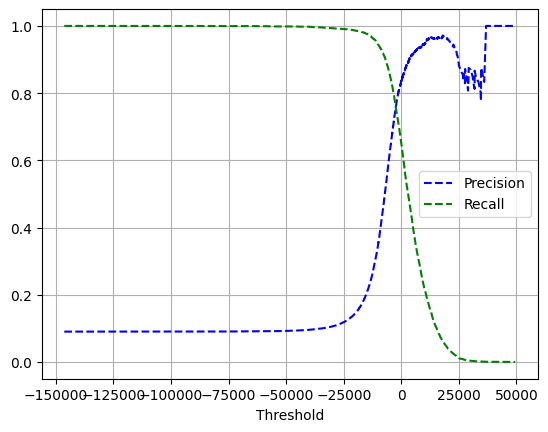

In [22]:
# second we use precision_recall_curve() functiomn to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [23]:
# if we want to find the lowest threshold to get 90% precision, we may use the following
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # 3370
threshold_90_precision

np.float64(3370.0194991439557)

In [24]:
# we can verify the precision and recall values for this threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90) # high precision achieved! (0.90)

0.9000345901072293

In [25]:
recall_score(y_train_5, y_train_pred_90) # but with a low recall (0.47) which means is not that useful

0.4799852425751706

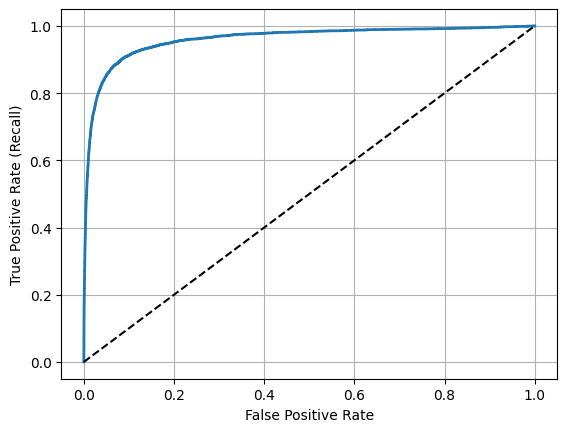

In [26]:
# let's plot the ROC curve (receiver operating characteristic), which is a plot of the sensitivity (recall) versus 1 - specificity
# sensitivity is the "true positive rate" (TPR), another form of recall, against the "false positive rate"
# FPR is the negative instances incorrectly classified as positive
# specificity is the "true negative rate" (TNR), which is ratio of negative instances correctly classified as negative
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1],[0, 1],'k--') # dashed diagonal
    plt.grid()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
# the importan aspect to analyze is the "area under the curve" (AUC)
# a perfect classifier will have a AUC = 1, while a purely random classifier will have a AUC = 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

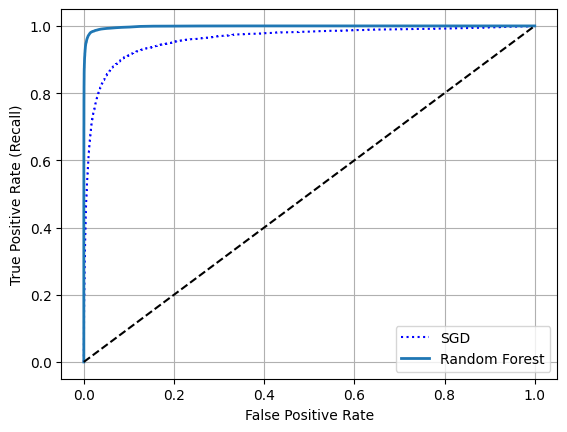

In [28]:
# let's compare the results with a RandomForestClassifier by calculating ROC and AUC
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = probability of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest) # much better AUC score for the RandomForestClassifier (0.99)

np.float64(0.9983436731328145)

In [30]:
y_train_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3) # let's find predictions to determine the precision and recall metrics
precision_score(y_train_5, y_train_forest) # high precision achieved! (0.99)

0.9905083315756169

In [31]:
recall_score(y_train_5, y_train_forest) # high recall also achieved! (0.86)

0.8662608374838591

In [32]:
# the next step is to model a classifier that detects more than just 5s
# we are going to start by using a Support Verctor Machine classifier
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5

# Support Vector Machine takes each category (digit) and creates a binary classifier that detects the selected digit vs another one
# i.e. takes the digit 1 and trains a model that detects between 1s and 0s, using a smaller trains set
# after training de model to distinguish 1s from 0s, it will train another one to detect 1s from 2s, and so forth with all other digits
# ones this has been done, it takes another digit and does the same process until having done this with all digits against all other digits
# this models are called OvO (one-versus-one), generating 45 classifiers (N * (N-1)/2), each using a reduced train set
# when you take one digit and ask the model to predict, it runs all the classifiers and take the one with higher score
svm_clf.predict([some_digit])

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [33]:
# let's take the scores for each category (digit) using the function decision_function()
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [34]:
np.argmax(some_digit_scores) # the higher score is indeed corresponding to class 5

np.int64(5)

In [35]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [36]:
svm_clf.classes_[5] # position 5 in the class vector, in this case happens to be the same value

np.uint8(5)

In [37]:
# as an example, let's force SVC so use the OvR (one-versus-rest) option instead of letting SciKit-Learn to choose between OvO or OvR
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but S

array([5], dtype=uint8)

In [38]:
len(ovr_clf.estimators_)

10

In [39]:
# let's use the SGDClassifier where SciKit-Learn uses a OvR strategy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # it's supposed to classified correctly and have a close score with class 3, but in this instance it predicted a 3 as a 5

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [40]:
# the SGD classifier trains 10 binary classifiers and generates scores for each one, taking the best prediction between them
sgd_clf.decision_function([some_digit]) # dropped a higher score for 3 than for 5... 

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [41]:
# we are going to evaluate this classifier using cross_val_score()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # random classifier would only have 10%, 85% is better but not enough

array([0.87365, 0.85835, 0.8689 ])

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # we can improve by scaling the train set
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [43]:
# to verify accuracy, let's look at the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

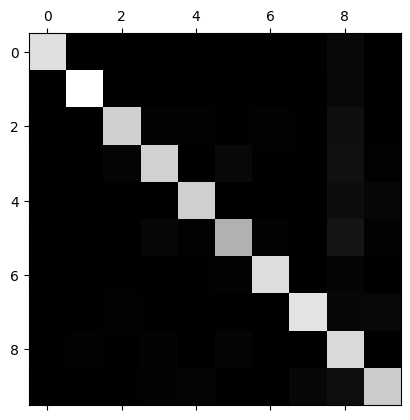

In [44]:
# for easier visualization let's create an image for the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

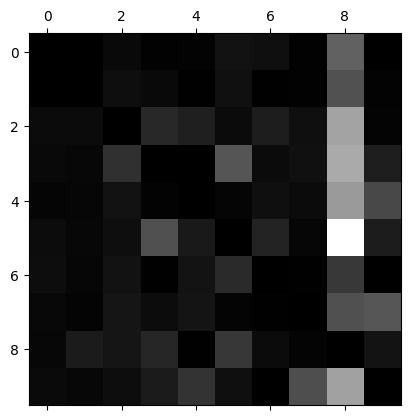

In [45]:
# let's focus the plot on the errors, so first we are going to divide each value in the confusion matrix by the number of images in the corresponding class
# this will allow us to compare error rates instead of absolute numbers of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0) # fills the diagonal with zeros to keep only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

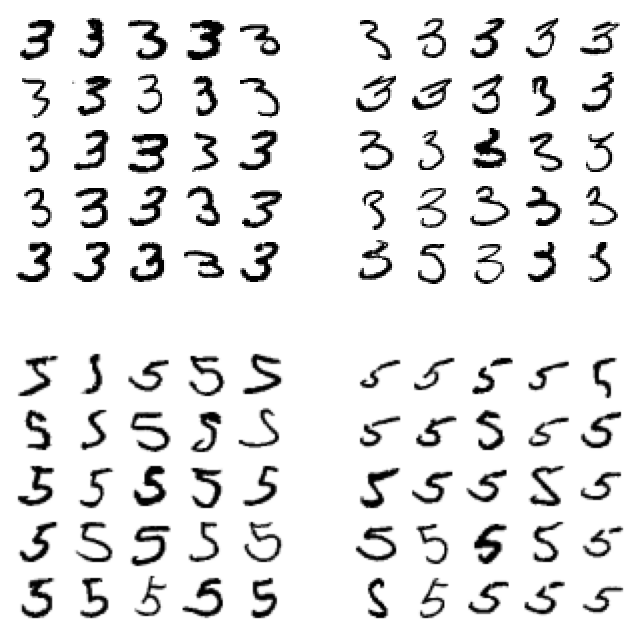

In [46]:
# a way to analyze the error matrix is to print some examples of 3s and 5s
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [47]:
# let's try to create a multilabel classification model
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) # dataset with numbers equal or greater than 7
y_train_odd = (y_train % 2 == 1) # data set of odd numbers
y_multilabel = np.c_[y_train_large, y_train_odd] # concatenation of both new target sets to create a two label target for the model

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [48]:
# let's generate the F1 score to determine performance
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [49]:
# we are going to test the last type of classification model called "multioutput multilabel classification" (or simply "multioutput classification")
# in this type of classification, each label can be multiclass
# we are going to build a system that removes noise from images, with an output that is a clear image, represented as an array of pixels intensities
# the classifier is multilabel, and each label has multiple outputs (pixel intensity ranges from 0 to 255)
# let's start by adding noise to the train set and test set of MNIST
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

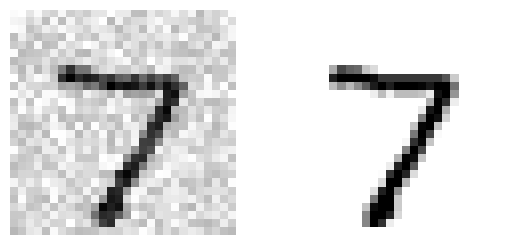

In [50]:
some_index = 60000 # test set starts at index 60000

plt.subplot(121); plot_digit(np.array(X_test_mod.loc[some_index]))
plt.subplot(122); plot_digit(np.array(y_test_mod.loc[some_index]))
plt.show()

d:\hands_on_machine_learning\C3 - Classification\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


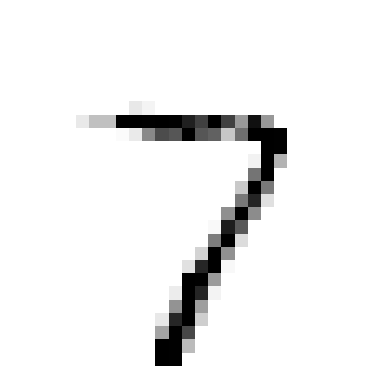

In [51]:
# let's now train the classifier and make it clean the images
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.loc[60000]])
plot_digit(np.array(clean_digit)) # looks close enough to the image with no added noise!
plt.show()